<a href="https://colab.research.google.com/github/song-pongpanit/human_stress/blob/main/Human_Stress_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Group3 : Human Stress Prediction**

Dataset : https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction

<p>    Stress detection is a challenging task, as there are so many words that can be used by people on their posts that can show whether a person is having psychological stress or not. look for datasets that you can use to train a machine learning model for stress detection.</p>

<p>The dataset contains data posted on subreddits related to mental health. This dataset contains various mental health problems shared by people about their life. Fortunately, this dataset is labelled as 0 and 1, where 0 indicates no stress and 1 indicates stress.</p>

<b>Data Dictionary</b>

1. subreddit

2. post_id 

3. sentence_range

4. text

5. label ( 0 = no stress , 1 = stress )

6. confidencel ( interval [0,1] )

7. social_timestemp

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

! pip install unidecode
from unidecode import unidecode
import re
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# <b>Data Importing</b>




In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Stress.csv to Stress (1).csv


In [ ]:
data = pd.read_csv('Stress.csv')
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [ ]:
data.shape

(2838, 7)

# <b>Data Preprocessing</b>

## Step 1 : Missing value


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2819 entries, 0 to 2818
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2819 non-null   object 
 1   post_id           2819 non-null   object 
 2   sentence_range    2819 non-null   object 
 3   text              2819 non-null   object 
 4   label             2819 non-null   int64  
 5   confidence        2819 non-null   float64
 6   social_timestamp  2819 non-null   int64  
 7   clean_text        2819 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 176.3+ KB


## Step 2 : Duplicate value


In [ ]:
data.shape[0] - data.nunique()

subreddit           2828
post_id              495
sentence_range      2665
text                  18
label               2836
confidence          2828
social_timestamp     495
dtype: int64

In [ ]:
data.loc[data.duplicated(subset='text')==True]

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
744,survivorsofabuse,62doqq,"(26, 31)",7. This study will include only participants w...,0,1.000000,1490877639
1220,ptsd,83z8rm,"(0, 5)",If you have a survey you would like to share w...,0,1.000000,1520894169
1592,anxiety,7ti69n,"[15, 20]",#NAME?,1,0.571429,1517114200
1661,stress,655dz7,"(24, 29)",7. This study will include only participants w...,0,1.000000,1492089318
1746,almosthomeless,6ssgax,"(5, 10)","Help me network, help me find a room, please! ...",1,0.800000,1502361160
1816,survivorsofabuse,8nkyhu,"(20, 25)","Because not really. I would have survived, I a...",1,0.600000,1527792409
1872,survivorsofabuse,9tgfdh,"(5, 10)",I'm new to this so please forgive me. I'm not ...,1,1.000000,1541128063
1905,survivorsofabuse,6238im,"(0, 5)",Can you contribute your story alongside others...,0,1.000000,1490745878
2092,stress,8b9j8h,"(0, 5)","Hello, You are invited to complete a survey fo...",0,1.000000,1523381550
2099,survivorsofabuse,998q0r,"(5, 10)",The current study explores the experience of y...,0,1.000000,1534898400


### Label error among duplicate text

In [ ]:
# Create dict to collect duplicat text (key) and number of duplicate (value)
data_dup = data[data.duplicated(subset='text')==True]['text']
dup_dict = defaultdict(int)
for txt in data_dup:
  dup_dict[txt] += 1

In [ ]:
label_error = defaultdict(lambda: "Not Present")
for txt in dup_dict.keys() :
  label = set(data[data['text'] == txt]['label'])
  label_error[txt] = label

for key,value in label_error.items():
  if len(value) > 1 :
    print('Sentence : {}'.format(key))
    print('Label : {}'.format(value))
    print('Index : {}'.format(data[data['text'] == key].index))
    data.loc[data[data['text'] == key].index,'label'] = 1           # Change label
    print('-------------')

Sentence : #NAME?
Label : {0, 1}
Index : Int64Index([295, 1592, 2190, 2563], dtype='int64')
-------------
Sentence : Because not really. I would have survived, I always have before, I have gone three and four days without eating a single thing on dozens of occasions in the last fifteen years, and I will be fine. The guy is wonderful, and has helped me a great deal. But it felt like an intentional attempt to act like I am a burdensome charity case. I just don't know.
Label : {0, 1}
Index : Int64Index([1612, 1816], dtype='int64')
-------------
Sentence : I refuse to carry both of us anymore and I'm also tired of the drama between us as well. So, part of me hopes he doesn't pay the rent and that'll give me my push to really move on. Anyway, I'm ok with going to a shelter, but I worry about my laptop. I remember when I was living in a shelter when I was a kid, they didn't allow you to have certain items. I don't want to part with my laptop for them to keep it safe and it gets "lost".
Label

In [ ]:
data.loc[[1612,530],['text','label']]

,text,label
1612,"Because not really. I would have survived, I a...",1
530,I refuse to carry both of us anymore and I'm a...,1


In [ ]:
# Drop duplicate text and unknown text
data.drop( data[data['text'] == '#NAME?'].index, inplace = True)
data.drop_duplicates(subset='text', inplace = True, ignore_index= True)

In [ ]:
data.shape

(2819, 7)

In [ ]:
data.duplicated(subset ='text').sum()

0

## Step 3 : Data transforming


Reference : https://www.kaggle.com/code/alrafiaurnob/human-stress-prediction-with-lstm#Cleaning-data (AL RAFI AURNOB, 2023)



```
 def clean_text(input)
```






> **Preprocess**


- Remove non-word chracters
- Replace extra spaces
- Remove all number except those attached to a word
- Remove all hypens except between 2 words
- Remove punctuation in text
- Transform text to lowercase
- Remove stop words



> **Lemmatize**

- Convert a word to its base form by spacy [en_core_web_sm]

> **listtostring**

- combine word list to string

In [ ]:
nlp=spacy.load('en_core_web_sm')

In [ ]:
# 1. preprocess 
def preprocess(text,remove_digits=True):
    if isinstance(text,str):
      text = re.sub('\W+',' ', text)                                        # Replace non-word characters
      text = re.sub('\s+',' ', text)                                        # Replace extra spaces
      text = re.sub("(?<!\w)\d+", "", text)                                 # Remove all numbers except those attached to a word
      text = re.sub("-(?!\w)|(?<!\w)-", "", text)                           # Remove all hyphens except between two words
      text=text.lower() if isinstance(text,str) else text                   # Transform text to lowercase
      nopunc=[char for char in text if char not in string.punctuation]      # Remove punctuation in the strings
      nopunc=''.join(nopunc)
      nopunc=' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])   # Remove stop words
      return nopunc
    else:
      return ''

# 2. Lemmatization     # Convert a word to its base form by spacy [en_core_web_sm]
def lemmatize(words):
    words=nlp(words)
    lemmas = []
    for word in words:
        lemmas.append(word.lemma_)
    return lemmas

# 3. Combine list to string
def listtostring(s):
    str1=' '
    return (str1.join(s))

def clean_text(input):
    word=preprocess(input)
    lemmas=lemmatize(word)
    return listtostring(lemmas)

In [ ]:
data['clean_text'] = data['text'].apply(clean_text)

In [ ]:
clean_data = data[['clean_text','label']]
clean_data.head(10)

,clean_text,label
0,say feel way suggete go rest trigger ahead you...,1
1,hey r assistance sure right place post go curr...,0
2,mom hit newspaper shock would know like play h...,1
3,meet new boyfriend amazing kind sweet good stu...,1
4,october domestic violence awareness month dome...,1
5,think want put effort relationship work diffic...,1
6,big company luckily see time act though exist ...,0
7,clear okay monday think human brain work trip ...,1
8,actually give assistant half emergency fee com...,1
9,feel like street life fuck head much even know...,1


## Step 4 : Exploring data




### Label Distribustion

In [ ]:
clean_data['label'].value_counts()/clean_data.shape[0]*100
# 1 : 1484      0 : 1335

1    52.642781
0    47.357219
Name: label, dtype: float64

Text(0.5, 1.0, 'Label Distribution')

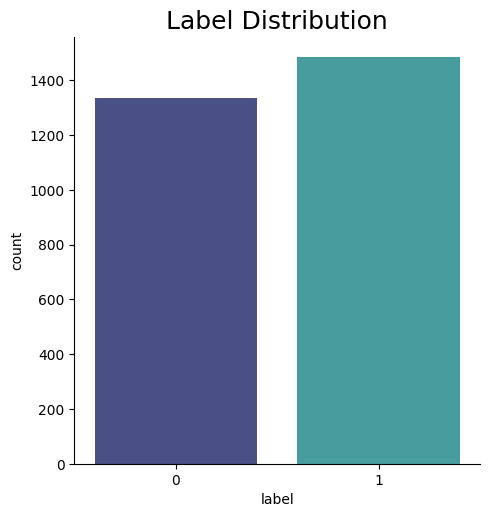

In [ ]:
plt.style.use('default')
sns.catplot(data = clean_data, kind = 'count', x = 'label', palette = 'mako')
plt.title('Label Distribution', fontsize = 18) 

### Total numbers of words

In [ ]:
count_text = set()
for caption in clean_data['clean_text'] :
  for i in caption.split(' ') :
    count_text.add( i )

print('Total words : ' , len(count_text))

Total words :  8688


### Distribution of word appearance in document at different level 

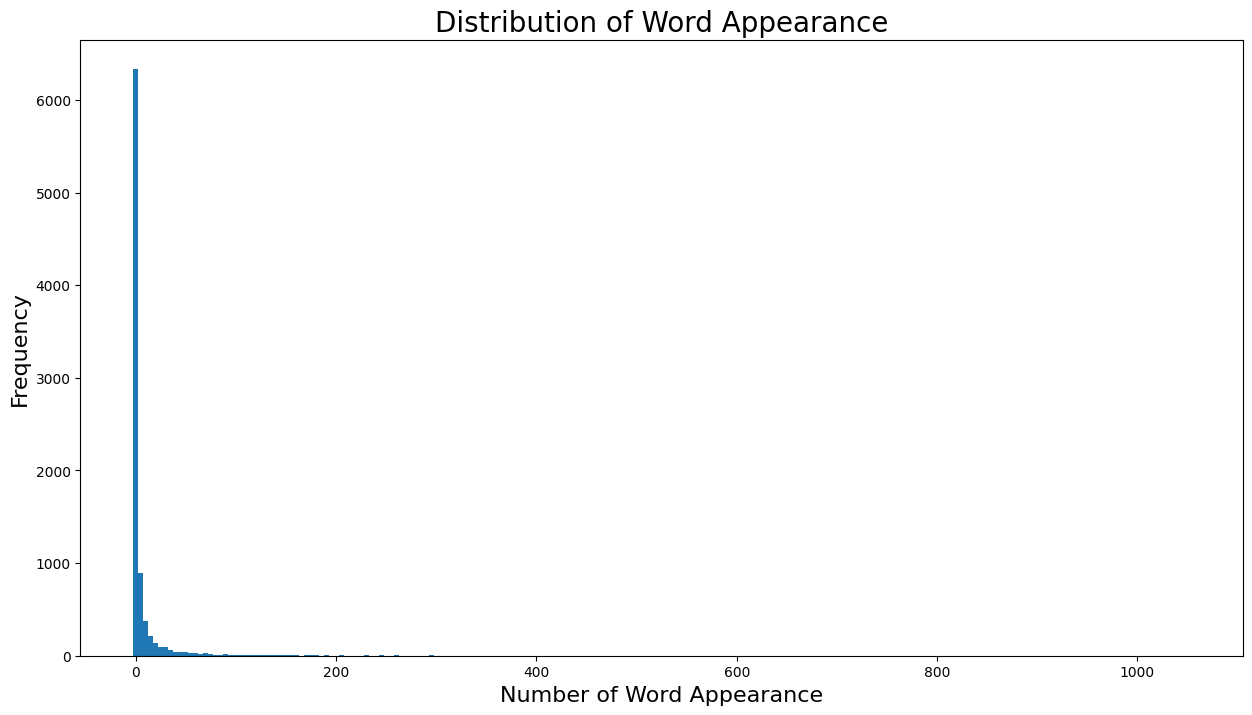

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# create a CountVectorizer object
count = CountVectorizer(binary=True)
x_b = count.fit_transform(clean_data['clean_text'])

# get the feature names
feature_names = count.get_feature_names_out()

# calculate the number of documents in which each word appears
doc_freq = x_b.sum(axis=0)

# create a dictionary of word frequencies
word_freq = {feature_names[i]:doc_freq[0, i] for i in range(len(feature_names))}

# bin the doc_freq for width 5
bins = np.arange(0, doc_freq.max() + 5, 5)
hist, edges = np.histogram(doc_freq, bins=bins)

# plot the histogram
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(edges[:-1], hist, width=5)
ax.set_xlabel('Number of Word Appearance', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Distribution of Word Appearance', fontsize=20)
plt.show()

### Distribution of text lengths

<ipython-input-44-5cf57dc21848>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['text_length'] = clean_data['clean_text'].apply(len)


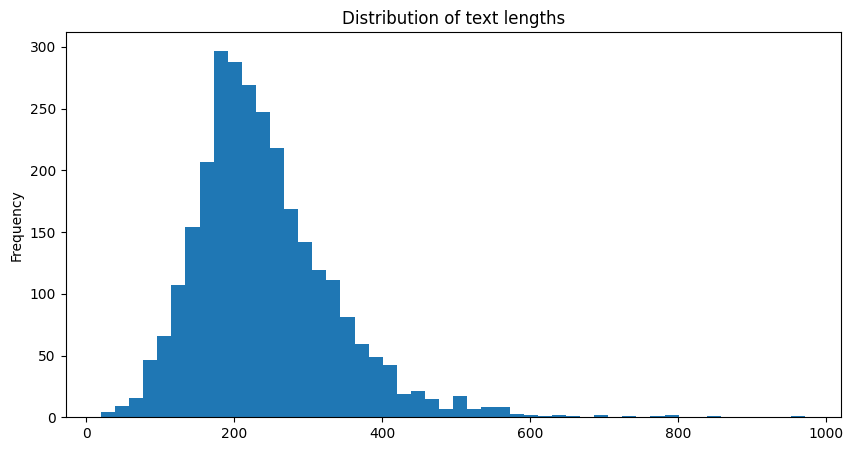

In [ ]:
clean_data['text_length'] = clean_data['clean_text'].apply(len)
clean_data['text_length'].plot(kind='hist', title='Distribution of text lengths', bins=50, figsize=(10,5))
plt.show()

### Word using in stress person

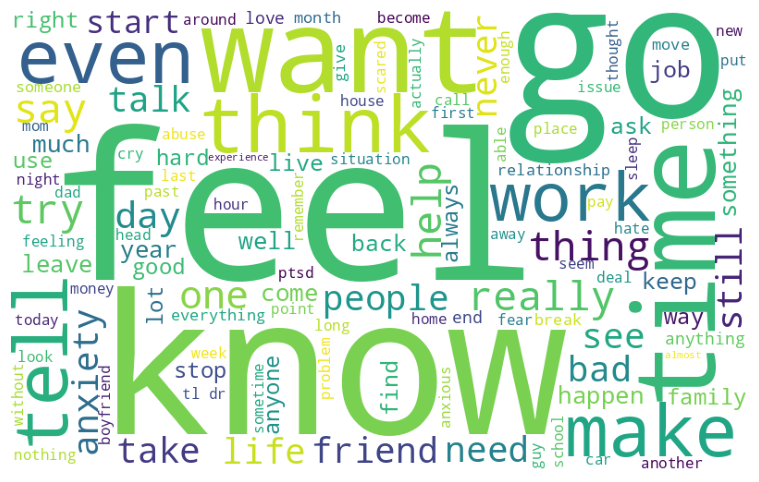

In [ ]:
text = ' '.join(caption for caption in clean_data[clean_data['label'] == 1]['clean_text'])
wordcloud = WordCloud(width = 800, height = 500,background_color='white', min_font_size = 10).generate(text) 
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud)   
plt.axis('off') 
plt.show()

### Word using in non-stress person

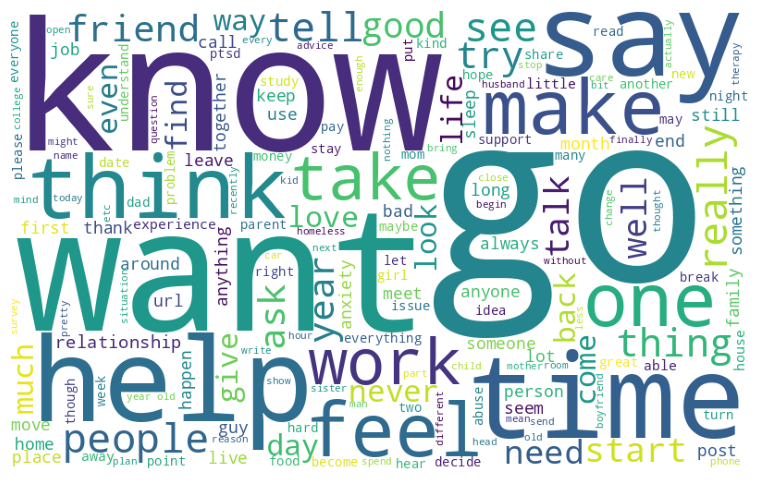

In [ ]:
text = ' '.join(caption for caption in clean_data[clean_data['label'] == 0]['clean_text'])
wordcloud = WordCloud(width = 800, height = 500,background_color='white', min_font_size = 10).generate(text) 
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud)   
plt.axis('off') 
plt.show()

# <b>Data Modeling</b>

In [ ]:
x = clean_data['clean_text'].values
y = clean_data['label'].values

print(x.shape, y.shape)

(2819,) (2819,)


### Split Data

In [ ]:
# Split data to train 64%, valid 16%, test 20%
x_train0, x_test, y_train0, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train0, y_train0, test_size=0.2, stratify=y_train0, random_state=42)

### Vectorize

transforming text data into a numerical format


```
fit_transform on training set
```


```
transform on validation and test set
```



In [ ]:
# vectorize the feature for bernoulli
tf_b = TfidfVectorizer(binary = True)
x_train_b = tf_b.fit_transform(x_train)
x_val_b = tf_b.transform(x_val)
x_test_b  = tf_b.transform(x_test)

# vectorize the feature for multinomial, logistic and svm
tf = TfidfVectorizer()  
x_train_v = tf.fit_transform(x_train)
x_val_v = tf.transform(x_val)
x_test_v  = tf.transform(x_test)

# <center><font color=#0EABF0> <b>Model1</b> : Naïve Bayes </font></center>



## Bernoulli Naïve Bayes Classifier 

### Default model with laplace smoothing (alpha = 1)

In [ ]:
BNB= BernoulliNB(alpha = 1)
BNB.fit(x_train_b, y_train)
y_pred_BNB_default = BNB.predict(x_test_b)

print('Predicted classes of the first 10 rows are {}'.format(y_pred_BNB_default[0:10]))
print('Target classes of the first 10 rows are {}'.format(y_test[0:10]))
print('\n')
print(classification_report(y_test, y_pred_BNB_default))

Predicted classes of the first 10 rows are [0 1 1 1 1 1 0 1 1 1]
Target classes of the first 10 rows are [0 1 1 0 1 0 0 1 0 1]


              precision    recall  f1-score   support

           0       0.79      0.58      0.67       267
           1       0.69      0.86      0.77       297

    accuracy                           0.73       564
   macro avg       0.74      0.72      0.72       564
weighted avg       0.74      0.73      0.72       564



### Adjusted thershold

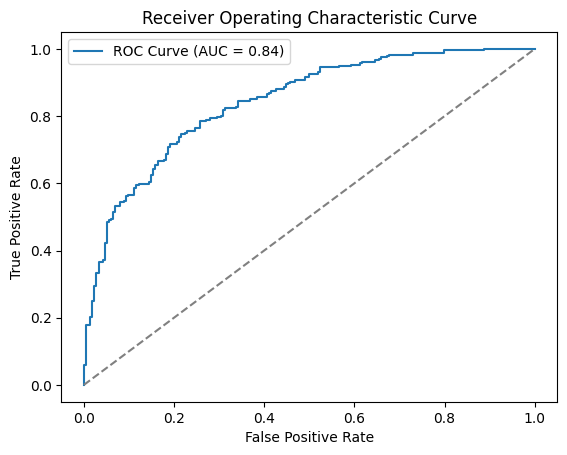

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Threshold that maximizes recall : 0.8912


In [ ]:
y_prob = BNB.predict_proba(x_val_b)[:, 1]

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
auc_score = roc_auc_score(y_val, y_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

# Choose the threshold that maximizes recall
max_recall_threshold = thresholds[np.argmax(tpr - fpr)]
print('----------------'*10)
print('Threshold that maximizes recall : {:.4f}'.format(max_recall_threshold))

In [ ]:
# Apply new threshold to model
threshold = max_recall_threshold.copy()
y_pred_prob_BNB = BNB.predict_proba(x_test_b)[:, 1]
y_pred_BNB_thr = (y_pred_prob_BNB >= threshold).astype(int)

print('Probability prediction of the first 10 rows are {}'.format(y_pred_prob_BNB[:10]))
print('\n')
print('Predicted classes of the first 10 rows are {}'.format(y_pred_BNB_thr[0:10]))
print('Target classes of the first 10 rows are {}'.format(y_test[0:10]))
print('\n')
print(classification_report(y_test, y_pred_BNB_thr))

Probability prediction of the first 10 rows are [0.01502668 0.99925704 0.99988951 0.60371344 0.99997151 0.56691389
 0.05662535 0.99851897 0.96174345 0.9966453 ]


Predicted classes of the first 10 rows are [0 1 1 0 1 0 0 1 1 1]
Target classes of the first 10 rows are [0 1 1 0 1 0 0 1 0 1]


              precision    recall  f1-score   support

           0       0.70      0.76      0.73       267
           1       0.77      0.71      0.74       297

    accuracy                           0.73       564
   macro avg       0.73      0.73      0.73       564
weighted avg       0.73      0.73      0.73       564



### Summary

In [ ]:
tbl_lr=pd.DataFrame()
tbl_lr['Model']=pd.Series(['Default', 'Threshold'])
tbl_lr['Accuracy']=pd.Series([accuracy_score(y_test, y_pred_BNB_default), accuracy_score(y_test, y_pred_BNB_thr)])
tbl_lr['F1_Score']=pd.Series([f1_score(y_test, y_pred_BNB_default), f1_score(y_test, y_pred_BNB_thr)])
tbl_lr['Recall_Score']=pd.Series([recall_score(y_test, y_pred_BNB_default),recall_score(y_test, y_pred_BNB_thr)])
tbl_lr['Precision_Score']=pd.Series([precision_score(y_test, y_pred_BNB_default),precision_score(y_test, y_pred_BNB_thr)])
tbl_lr.set_index('Model')

,Accuracy,F1_Score,Recall_Score,Precision_Score
Model,,,,
Default,0.72695,0.768769,0.861953,0.693767
Threshold,0.73227,0.735552,0.707071,0.766423


## Multinomial Naïve Bayes Classifier

### Default with smoothing (alpha = 1)

In [ ]:
MNB = MultinomialNB(alpha = 1)
MNB.fit(x_train_v, y_train)
y_pred_MNB_default = MNB.predict(x_test_v)

print('Predicted classes of the first 10 rows are {}'.format(y_pred_MNB_default[0:10]))
print('Target classes of the first 10 rows are {}'.format(y_test[0:10]))
print('\n')
print(classification_report(y_test, y_pred_MNB_default))

Predicted classes of the first 10 rows are [0 1 1 1 1 0 0 1 1 1]
Target classes of the first 10 rows are [0 1 1 0 1 0 0 1 0 1]


              precision    recall  f1-score   support

           0       0.87      0.38      0.53       267
           1       0.63      0.95      0.76       297

    accuracy                           0.68       564
   macro avg       0.75      0.66      0.64       564
weighted avg       0.74      0.68      0.65       564



### Adjusted threshold

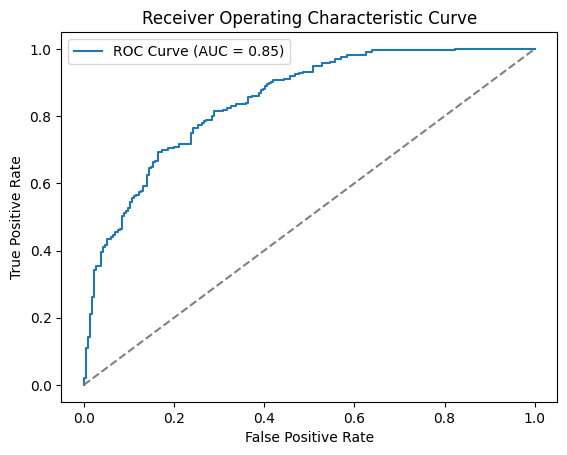

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Threshold that maximizes recall: 0.6559


In [ ]:
y_prob = MNB.predict_proba(x_val_v)[:, 1]

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
auc_score = roc_auc_score(y_val, y_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

# Choose the threshold that maximizes recall
max_recall_threshold = thresholds[np.argmax(tpr - fpr)]
print('----------------'*10)
print('Threshold that maximizes recall: {:.4f}'.format(max_recall_threshold))

In [ ]:
# Apply new threshold to model
threshold = max_recall_threshold.copy()
y_pred_prob_MNB = MNB.predict_proba(x_test_v)[:, 1]
y_pred_MNB_thr = (y_pred_prob_MNB >= threshold).astype(int)

print('Probability prediction of the first 10 rows are {}'.format(y_pred_prob_MNB[:10]))
print('\n')
print('Predicted classes of the first 10 rows are {}'.format(y_pred_MNB_thr[0:10]))
print('Target classes of the first 10 rows are {}'.format(y_test[0:10]))
print('\n')
print(classification_report(y_test, y_pred_MNB_thr))

Probability prediction of the first 10 rows are [0.44440032 0.78898126 0.87189594 0.53283165 0.80037191 0.49554238
 0.43861227 0.76637685 0.65994841 0.68803769]


Predicted classes of the first 10 rows are [0 1 1 0 1 0 0 1 1 1]
Target classes of the first 10 rows are [0 1 1 0 1 0 0 1 0 1]


              precision    recall  f1-score   support

           0       0.68      0.81      0.74       267
           1       0.79      0.66      0.72       297

    accuracy                           0.73       564
   macro avg       0.74      0.73      0.73       564
weighted avg       0.74      0.73      0.73       564



### Summary

In [ ]:
tbl_lr=pd.DataFrame()
tbl_lr['Model']=pd.Series(['Default', 'Threshold'])
tbl_lr['Accuracy']=pd.Series([accuracy_score(y_test, y_pred_MNB_default), accuracy_score(y_test, y_pred_MNB_thr)])
tbl_lr['F1_Score']=pd.Series([f1_score(y_test, y_pred_MNB_default), f1_score(y_test, y_pred_MNB_thr)])
tbl_lr['Recall_Score']=pd.Series([recall_score(y_test, y_pred_MNB_default),recall_score(y_test, y_pred_MNB_thr)])
tbl_lr['Precision_Score']=pd.Series([precision_score(y_test, y_pred_MNB_default),precision_score(y_test, y_pred_MNB_thr)])
tbl_lr.set_index('Model')

,Accuracy,F1_Score,Recall_Score,Precision_Score
Model,,,,
Default,0.679078,0.757047,0.949495,0.629464
Threshold,0.728723,0.718232,0.656566,0.792683


# <center><font color=#0EABF0> <b>Model2</b> : Logistic Regression</font></center>


### Default Model (C=1, penalty = 'l2', solver = 'lbfgs', max_iter = 100)


*   C : Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. Usually in term of 10^n
*   penalty : Term of penalty. 'l1' (Lasso) and 'l2' (Ridge)
*   solver : Algorithm to use in the optimization problem. 'lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’
*   max_iter : Maximum number of iterations taken for the solvers to converge.





In [ ]:
lr_default = LogisticRegression()
lr_default.fit(x_train_v, y_train)

LogisticRegression()

In [ ]:
y_pred_lrdefault = lr_default.predict(x_test_v)

print('Predicted classes of the first 10 rows are {}'.format(y_pred_lrdefault[0:10]))
print('Target classes of the first 10 rows are {}'.format(y_test[0:10]))
print('\n')
print(classification_report(y_test, y_pred_lrdefault))

Predicted classes of the first 10 rows are [0 1 1 0 1 0 0 1 1 1]
Target classes of the first 10 rows are [0 1 1 0 1 0 0 1 0 1]


              precision    recall  f1-score   support

           0       0.73      0.67      0.70       267
           1       0.73      0.78      0.75       297

    accuracy                           0.73       564
   macro avg       0.73      0.73      0.73       564
weighted avg       0.73      0.73      0.73       564



### Hyperparameter tuning

C Parameter vs F1

In [ ]:
c_train_f1 = dict()
c_val_f1 = dict()
Param_C = []

for n in range(-5,20,1):
  lr = LogisticRegression(C = 10**n, max_iter = 200)
  lr.fit(x_train_v, y_train)
  y_pred_train = lr.predict(x_train_v)
  y_pred_val = lr.predict(x_val_v)
  Param_C.append(10**n) 
  c_train_f1[n] = f1_score(y_train,y_pred_train)*100
  c_val_f1[n] = f1_score(y_val,y_pred_val)*100

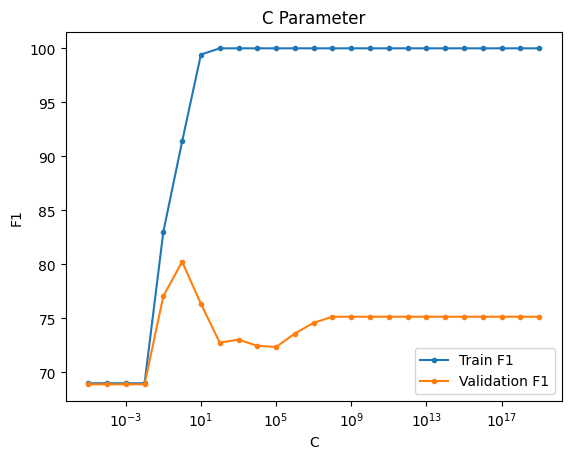

In [ ]:
plt.title("C Parameter") 
plt.plot(Param_C, c_train_f1.values(), marker='.', label='Train F1')
plt.plot(Param_C, c_val_f1.values(), marker='.', label="Validation F1")
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("F1")
plt.legend()
plt.show()

### GridSearch

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'C': [1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga'], 'max_iter' : [5000]}
lr = LogisticRegression()
grid_search = GridSearchCV(lr, param_grid, cv=kf, scoring='f1', return_train_score=False, verbose=1)

best_lr = grid_search.fit(x_train_v, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
print("Best hyperparameters: ", best_lr.best_params_)
print("Best score: {:.4f}".format(best_lr.best_score_*100))

Best hyperparameters:  {'C': 1, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 73.6457


In [ ]:
y_pred_lrgrid = best_lr.predict(x_test_v)

print('Predicted classes of the first 10 rows are {}'.format(y_pred_lrgrid[0:10]))
print('Target classes of the first 10 rows are {}'.format(y_test[0:10]))
print('\n')
print(classification_report(y_test, y_pred_lrgrid))

Predicted classes of the first 10 rows are [0 1 1 0 1 0 0 1 1 1]
Target classes of the first 10 rows are [0 1 1 0 1 0 0 1 0 1]


              precision    recall  f1-score   support

           0       0.73      0.67      0.70       267
           1       0.73      0.78      0.75       297

    accuracy                           0.73       564
   macro avg       0.73      0.73      0.73       564
weighted avg       0.73      0.73      0.73       564



### Adjusted threshold

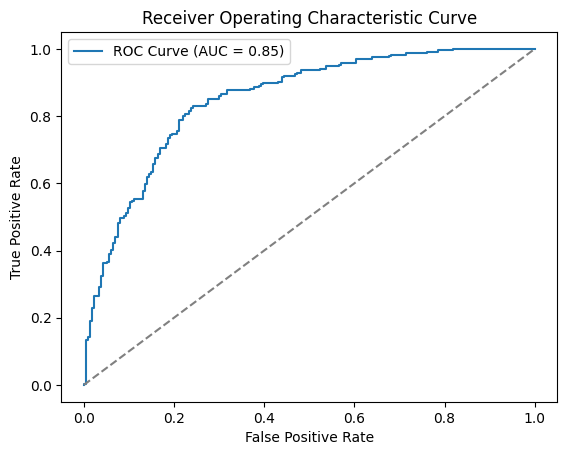

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Threshold that maximizes recall: 0.4983


In [ ]:
y_lrprob = best_lr.predict_proba(x_val_v)[:, 1]

# Compute the ROC curve and AUC score
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_val, y_lrprob)
lr_auc_score = roc_auc_score(y_val, y_lrprob)

# Plot the ROC curve
plt.plot(lr_fpr, lr_tpr, label='ROC Curve (AUC = {:.2f})'.format(lr_auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

# Choose the threshold that maximizes recall
max_recall_lrthreshold = lr_thresholds[np.argmax(lr_tpr - lr_fpr)]
print('----------------'*10)
print('Threshold that maximizes recall: {:.4f}'.format(max_recall_lrthreshold))

In [ ]:
# Apply new threshold to model
lr_threshold = max_recall_lrthreshold.copy()
y_pred_lrprob = best_lr.predict_proba(x_test_v)[:, 1]
y_pred_lrthres = (y_pred_lrprob >= lr_threshold).astype(int)

print('Probability prediction of the first 10 rows are {}'.format(y_pred_lrprob[:10]))
print('\n')
print('Predicted classes of the first 10 rows are {}'.format(y_pred_lrthres[:10]))
print('Target classes of the first 10 rows are {}'.format(y_test[0:10]))
print('\n')
print(classification_report(y_test, y_pred_lrthres))

Probability prediction of the first 10 rows are [0.29101084 0.80705998 0.84345034 0.48531337 0.78712571 0.40295706
 0.34599976 0.66787162 0.53921259 0.52463449]


Predicted classes of the first 10 rows are [0 1 1 0 1 0 0 1 1 1]
Target classes of the first 10 rows are [0 1 1 0 1 0 0 1 0 1]


              precision    recall  f1-score   support

           0       0.74      0.67      0.70       267
           1       0.73      0.78      0.76       297

    accuracy                           0.73       564
   macro avg       0.73      0.73      0.73       564
weighted avg       0.73      0.73      0.73       564



### Summary

In [ ]:
tbl_lr=pd.DataFrame()
tbl_lr['Model']=pd.Series(['Default', 'Gridsearch','Gridsearch and Threshold'])
tbl_lr['Accuracy']=pd.Series([accuracy_score(y_test,y_pred_lrdefault),accuracy_score(y_test, y_pred_lrgrid),accuracy_score(y_test, y_pred_lrthres)])
tbl_lr['F1_Score']=pd.Series([f1_score(y_test,y_pred_lrdefault),f1_score(y_test, y_pred_lrgrid),f1_score(y_test, y_pred_lrthres)])
tbl_lr['Recall_Score']=pd.Series([recall_score(y_test,y_pred_lrdefault),recall_score(y_test, y_pred_lrgrid),recall_score(y_test, y_pred_lrthres)])
tbl_lr['Precision_Score']=pd.Series([precision_score(y_test,y_pred_lrdefault),precision_score(y_test, y_pred_lrgrid),precision_score(y_test, y_pred_lrthres)])
tbl_lr.set_index('Model')

,Accuracy,F1_Score,Recall_Score,Precision_Score
Model,,,,
Default,0.730496,0.753247,0.781145,0.727273
Gridsearch,0.730496,0.753247,0.781145,0.727273
Gridsearch and Threshold,0.732270,0.755267,0.784512,0.728125


# <center><font color=#0EABF0> <b>Model3</b> : Support Vector Machine </font></center>


### Default Model (C=1, gamma = 'scale', kernel = 'rbf')


*   C : Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
*   gamma : Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
*   kernel : Specifies the kernel type to be used in the algorithm.

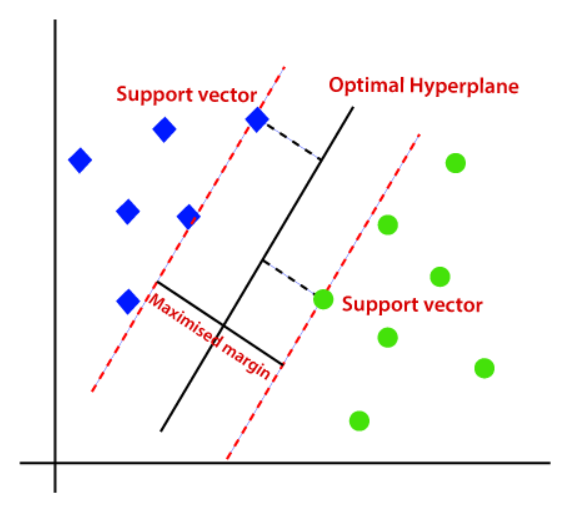



In [ ]:
svm = SVC(random_state=42)
svm.fit(x_train_v, y_train)

SVC(random_state=42)

In [ ]:
y_pred_svmd = svm.predict(x_test_v)

print('Predicted classes of the first 10 rows are {}'.format(y_pred_svmd[0:10]))
print('Target classes of the first 10 rows are {}'.format(y_test[0:10]))
print('\n')
print(classification_report(y_test, y_pred_svmd))

Predicted classes of the first 10 rows are [0 1 1 0 1 0 0 1 1 1]
Target classes of the first 10 rows are [0 1 1 0 1 0 0 1 0 1]


              precision    recall  f1-score   support

           0       0.72      0.69      0.70       267
           1       0.73      0.75      0.74       297

    accuracy                           0.72       564
   macro avg       0.72      0.72      0.72       564
weighted avg       0.72      0.72      0.72       564



### Hyperparameter tuning

C Parameter VS F1

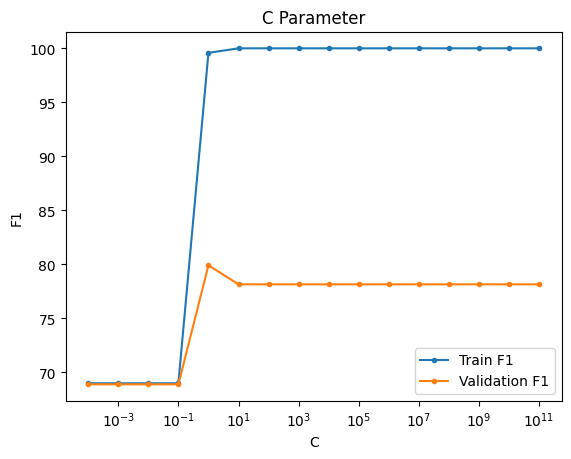

In [ ]:
c_train_f1 = dict()
c_val_f1 = dict()
Param_C = []

for n in range(-4,12,1):
  svm = SVC(random_state=42, C = 10**n)
  svm.fit(x_train_v, y_train)
  y_pred_train = svm.predict(x_train_v)
  y_pred_val = svm.predict(x_val_v)
  Param_C.append(10**n) 
  c_train_f1[n] = f1_score(y_train,y_pred_train)*100
  c_val_f1[n] = f1_score(y_val,y_pred_val)*100
    
### Plot 
plt.title("C Parameter") 
plt.plot(Param_C, c_train_f1.values(), marker='.', label='Train F1')
plt.plot(Param_C, c_val_f1.values(), marker='.', label="Validation F1")
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("F1")
plt.legend()
plt.show()

Gamma Parameter VS F1

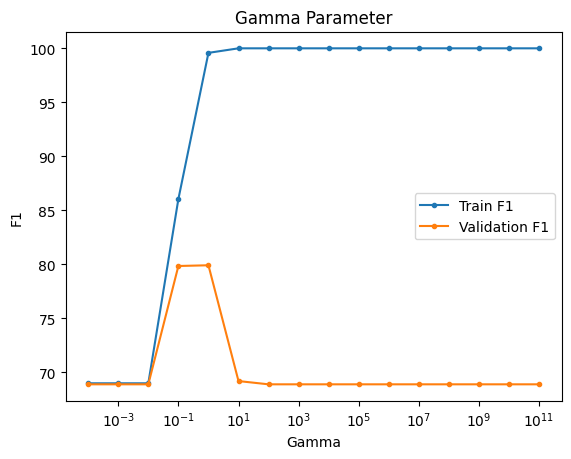

In [ ]:
gamma_train_f1 = dict()
gamma_val_f1 = dict()
Param_gamma = []

for n in range(-4,12,1):
  svm = SVC(random_state=42, gamma = 10**n)
  svm.fit(x_train_v, y_train)
  y_pred_train = svm.predict(x_train_v)
  y_pred_val = svm.predict(x_val_v)
  Param_gamma.append(10**n) 
  gamma_train_f1[n] = f1_score(y_train,y_pred_train)*100
  gamma_val_f1[n] = f1_score(y_val,y_pred_val)*100
    
### Plot 
plt.title("Gamma Parameter") 
plt.plot(Param_gamma, gamma_train_f1.values(), marker='.', label='Train F1')
plt.plot(Param_gamma, gamma_val_f1.values(), marker='.', label="Validation F1")
plt.xscale('log')
plt.xlabel("Gamma")
plt.ylabel("F1")
plt.legend()
plt.show()

### GridSearch

In [ ]:
param_svm = {'C': [0.1, 1, 10], 
              'gamma': [0.1, 1, 10],
              'kernel': ['rbf','linear','poly','sigmoid']} 

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_grid = GridSearchCV(svm, param_svm, cv=kf, scoring='f1', return_train_score=False, verbose=1)

best_svm = svm_grid.fit(x_train_v,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
print('Best parameters : ', best_svm.best_params_)
print('Best score: {:.4f}'.format(best_svm.best_score_ *100))

Best parameters :  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 74.3836


In [ ]:
y_pred_svmt = best_svm.predict(x_test_v)

print('Predicted classes of the first 10 rows are {}'.format(y_pred_svmt[0:10]))
print('Target classes of the first 10 rows are {}'.format(y_test[0:10]))
print('\n')
print(classification_report(y_test, y_pred_svmt))

Predicted classes of the first 10 rows are [0 1 1 1 1 0 0 1 1 1]
Target classes of the first 10 rows are [0 1 1 0 1 0 0 1 0 1]


              precision    recall  f1-score   support

           0       0.79      0.51      0.62       267
           1       0.66      0.88      0.76       297

    accuracy                           0.70       564
   macro avg       0.73      0.69      0.69       564
weighted avg       0.73      0.70      0.69       564



### Summary

In [ ]:
tbl_svm=pd.DataFrame()
tbl_svm['Model']=pd.Series(['Default', 'Gridsearch'])
tbl_svm['Accuracy']=pd.Series([accuracy_score(y_test, y_pred_svmd), accuracy_score(y_test, y_pred_svmt)])
tbl_svm['F1_Score']=pd.Series([f1_score(y_test, y_pred_svmd), f1_score(y_test, y_pred_svmt)])
tbl_svm['Recall_Score']=pd.Series([recall_score(y_test, y_pred_svmd), recall_score(y_test, y_pred_svmt)])
tbl_svm['Precision_Score']=pd.Series([precision_score(y_test, y_pred_svmd), precision_score(y_test, y_pred_svmt)])
tbl_svm.set_index('Model')

,Accuracy,F1_Score,Recall_Score,Precision_Score
Model,,,,
Default,0.723404,0.741722,0.754209,0.729642
Gridsearch,0.703901,0.758321,0.882155,0.664975


# <b>Model Comparison</b>


In [ ]:
tbl=pd.DataFrame()
tbl['Model']=pd.Series(['Bernoulli NB', 'Multinomial NB','Logistic Regression','Support Vector Machine'])
tbl['Accuracy']=pd.Series([ accuracy_score(y_test, y_pred_BNB_thr), accuracy_score(y_test, y_pred_MNB_thr), 
                           accuracy_score(y_test, y_pred_lrthres), accuracy_score(y_test, y_pred_svmt)])
tbl['F1_Score']=pd.Series([ f1_score(y_test, y_pred_BNB_thr), f1_score(y_test, y_pred_MNB_thr), 
                           f1_score(y_test, y_pred_lrthres),f1_score(y_test, y_pred_svmt)])
tbl['Recall_Score']=pd.Series([ recall_score(y_test, y_pred_BNB_thr), recall_score(y_test, y_pred_MNB_thr), 
                               recall_score(y_test, y_pred_lrthres),recall_score(y_test, y_pred_svmt)])
tbl['Precision_Score']=pd.Series([ precision_score(y_test, y_pred_BNB_thr), precision_score(y_test, y_pred_MNB_thr), 
                                  precision_score(y_test, y_pred_lrthres),precision_score(y_test, y_pred_svmt)])
tbl.set_index('Model')

,Accuracy,F1_Score,Recall_Score,Precision_Score
Model,,,,
Bernoulli NB,0.732270,0.735552,0.707071,0.766423
Multinomial NB,0.728723,0.718232,0.656566,0.792683
Logistic Regression,0.732270,0.755267,0.784512,0.728125
Support Vector Machine,0.703901,0.758321,0.882155,0.664975


In [ ]:
tbl.sort_values('F1_Score',ascending=False).set_index('Model')

,Accuracy,F1_Score,Recall_Score,Precision_Score
Model,,,,
Support Vector Machine,0.703901,0.758321,0.882155,0.664975
Logistic Regression,0.732270,0.755267,0.784512,0.728125
Bernoulli NB,0.732270,0.735552,0.707071,0.766423
Multinomial NB,0.728723,0.718232,0.656566,0.792683
